---
# 1. Import Modules 
<span id="Importmodules"></span>

---

In [11]:
%pip install -r requirements.txt

  Using cached tzdata-2025.1-py2.py3-none-any.whl.metadata (1.4 kB)
INFO: pip is looking at multiple versions of jax to determine which version is compatible with other requirements. This could take a while.
Using cached tzdata-2025.1-py2.py3-none-any.whl (346 kB)
   ---------------------------------------- 0.0/2.1 MB ? eta -:--:--
   ---------------------------------- ----- 1.8/2.1 MB 12.6 MB/s eta 0:00:01
   ---------------------------------------- 2.1/2.1 MB 10.0 MB/s eta 0:00:00
   ---------------------------------------- 0.0/55.2 MB ? eta -:--:--
   - -------------------------------------- 2.1/55.2 MB 9.8 MB/s eta 0:00:06
   -- ------------------------------------- 3.9/55.2 MB 9.0 MB/s eta 0:00:06
   ---- ----------------------------------- 6.0/55.2 MB 9.5 MB/s eta 0:00:06
   ----- ---------------------------------- 7.6/55.2 MB 8.9 MB/s eta 0:00:06
   ------ --------------------------------- 9.4/55.2 MB 8.9 MB/s eta 0:00:06
   -------- ------------------------------- 11.3/55.2 MB 

  You can safely remove it manually.
  You can safely remove it manually.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pyresparser 1.0.6 requires pdfminer.six>=20181108, which is not installed.


In [36]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import joblib
import tensorflow as tf
import os
import warnings
warnings.filterwarnings("ignore")

In [13]:
import os
import shutil
from sklearn.model_selection import train_test_split

def split_data(input_folder, output_folder, test_size=0.2):
    """
    Splits the data in the input folder into train and test sets and saves them in the output folder.

    Parameters:
        input_folder (str): Path to the folder containing the dataset.
        output_folder (str): Path to save the train and test datasets.
        test_size (float): Proportion of the dataset to include in the test split.
    """
    # Create output folders for train and test
    train_folder = os.path.join(output_folder, 'train')
    test_folder = os.path.join(output_folder, 'test')

    os.makedirs(train_folder, exist_ok=True)
    os.makedirs(test_folder, exist_ok=True)

    # Iterate through each class folder
    for class_name in os.listdir(input_folder):
        class_folder = os.path.join(input_folder, class_name)

        if os.path.isdir(class_folder):
            # Get all files in the class folder
            files = [f for f in os.listdir(class_folder) if os.path.isfile(os.path.join(class_folder, f))]

            # Split files into train and test
            train_files, test_files = train_test_split(files, test_size=test_size, random_state=42)

            # Create class folders in train and test directories
            train_class_folder = os.path.join(train_folder, class_name)
            test_class_folder = os.path.join(test_folder, class_name)

            os.makedirs(train_class_folder, exist_ok=True)
            os.makedirs(test_class_folder, exist_ok=True)

            # Copy files to train and test folders
            for file in train_files:
                shutil.copy(os.path.join(class_folder, file), os.path.join(train_class_folder, file))

            for file in test_files:
                shutil.copy(os.path.join(class_folder, file), os.path.join(test_class_folder, file))

    print(f"Data split completed. Train and test sets saved in '{output_folder}'.")

# Example usage
input_folder = 'asl_dataset\asl_dataset'
output_folder = 'split__data\split__data'
test_size = 0.1# 10% data for testing

split_data(input_folder, output_folder, test_size)


Data split completed. Train and test sets saved in 'C:\Users\shaik\OneDrive\Desktop\MAJOR PROJECT_FINAL\MAJOR PROJECT\MAJOR PROJECT\split__data'.


In [58]:
# Load and preprocess the dataset
train_dir = r"C:\Users\shaik\OneDrive\Desktop\MAJOR PROJECT_FINAL\MAJOR PROJECT\MAJOR PROJECT\split__data\split__data\train"
test_dir = r"C:\Users\shaik\OneDrive\Desktop\MAJOR PROJECT_FINAL\MAJOR PROJECT\MAJOR PROJECT\split__data\split__data\test"

In [59]:
# ImageDataGenerator for loading and augmenting images
datagen = ImageDataGenerator(rescale=1./255)

---
# 2. Load images with augmentation
<span id="Importmodules"></span>

---

In [73]:
# Load images from the training directory
train_data_gen = datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

# Load images from the testing directory
test_data_gen = datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

Found 1633 images belonging to 26 classes.
Found 182 images belonging to 26 classes.


In [61]:
#Step 1: Load MobileNet as a feature extractor
base_model = MobileNet(weights='imagenet', include_top=False)

# Add a Global Average Pooling layer to extract features
x = base_model.output
x = GlobalAveragePooling2D()(x)
feature_extractor = Model(inputs=base_model.input, outputs=x)

# Freeze the layers of MobileNet to use it as a feature extractor
for layer in base_model.layers:
    layer.trainable = False

# Step 2: Extract features for training and testing data
def extract_features(data_generator):
    features = []
    labels = []
    
    # Loop through batches of images and extract features
    for images, batch_labels in data_generator:
        # Extract features from the MobileNet model
        feature_batch = feature_extractor.predict(images)
        features.append(feature_batch)
        labels.append(batch_labels)
        
        # If we have enough data, stop
        if len(features) * data_generator.batch_size >= data_generator.samples:
            break
    
    # Convert to numpy arrays
    features = np.vstack(features)
    labels = np.vstack(labels)
    return features, labels

# Extract features for train data
X_train_features, y_train_labels = extract_features(train_data_gen)

# Extract features for test data
X_test_features, y_test_labels = extract_features(test_data_gen)

# Step 3: Save the extracted features to .joblib files
joblib.dump((X_train_features, y_train_labels), 'train.joblib')
joblib.dump((X_test_features, y_test_labels), 'test.joblib')

# Step 4: Split the training data into training and validation sets (80% training, 20% validation)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_features, y_train_labels, test_size=0.2, random_state=42
)

# Optionally, save the split data to .joblib files
joblib.dump((X_train, y_train), 'train_split.joblib')
joblib.dump((X_val, y_val), 'val_split.joblib')

# Saved in 'train.joblib' and 'test.joblib'
print("Features extracted and saved to 'train.joblib' and 'test.joblib'.")

1/1 [==============================] - 0s 441ms/step
Features extracted and saved to 'train.joblib' and 'test.joblib'.


---
# 3. Mobilenet Model
<span id="Importmodules"></span>

---

In [62]:
import numpy as np
import joblib
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout,GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
import seaborn as sns
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input


# Load the features extracted previously
X_train_features, y_train_labels = joblib.load('train_split.joblib')
X_val, y_val = joblib.load('val_split.joblib')
X_test_features, y_test_labels = joblib.load('test.joblib')

# If the labels are not already one-hot encoded, we can one-hot encode them
num_classes = y_train_labels.shape[1]  

input_shape = X_train_features.shape[1]  # The number of features per sample (1024 in this case)

# Define the model for classification
input_layer = Input(shape=(input_shape,))  # This is the shape of the features (1024,)
x = Dropout(0.5)(input_layer)  # Dropout to reduce overfitting
x = Dense(1024, activation='relu')(x)  # Fully connected layer with ReLU activation
x = Dropout(0.5)(x)  # Another Dropout layer
output_layer = Dense(num_classes, activation='softmax')(x)  # Output layer with softmax for multi-class classification

# Create the model
model = Model(inputs=input_layer, outputs=output_layer)

# Compile the model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train_features, y_train_labels, 
                    epochs=5, batch_size=32, 
                    validation_data=(X_val, y_val))


Epoch 1/5
57/57 [==============================] - 4s 27ms/step - loss: 2.7361 - accuracy: 0.2575 - val_loss: 1.0628 - val_accuracy: 0.7439
Epoch 2/5
57/57 [==============================] - 1s 18ms/step - loss: 1.2038 - accuracy: 0.6238 - val_loss: 0.5383 - val_accuracy: 0.8300
Epoch 3/5
57/57 [==============================] - 1s 20ms/step - loss: 0.7846 - accuracy: 0.7547 - val_loss: 0.3727 - val_accuracy: 0.8852
Epoch 4/5
57/57 [==============================] - 1s 19ms/step - loss: 0.5736 - accuracy: 0.8044 - val_loss: 0.3029 - val_accuracy: 0.9029
Epoch 5/5
57/57 [==============================] - 1s 19ms/step - loss: 0.5658 - accuracy: 0.8160 - val_loss: 0.2822 - val_accuracy: 0.9007


---
# 4. Plot training and validation accuracy
<span id="Importmodules"></span>

---

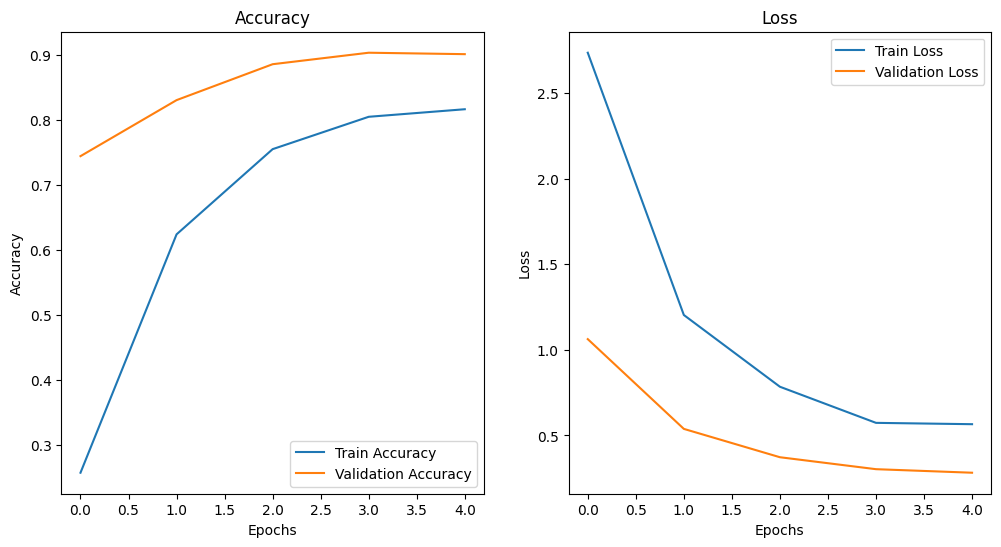

In [63]:
# Plot accuracy and loss
plt.figure(figsize=(12, 6))

# Plot training & validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [64]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test_features, y_test_labels, verbose=1)
print(f"Test accuracy: {test_accuracy:.4f}")
print(f"Test loss: {test_loss:.4f}")

# Make predictions on the test set
y_pred = model.predict(X_test_features)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test_labels, axis=1)

8/8 [==============================] - 0s 5ms/step - loss: 0.1995 - accuracy: 0.9325
Test accuracy: 0.9325
Test loss: 0.1995
8/8 [==============================] - 0s 5ms/step


---
# 5. Confusion Matrix and Classification Report
<span id="Importmodules"></span>

---

Confusion Matrix:
[[1 0 0 ... 0 0 0]
 [0 7 0 ... 0 0 0]
 [0 0 6 ... 0 0 0]
 ...
 [0 0 0 ... 7 0 0]
 [0 0 0 ... 0 7 0]
 [0 0 0 ... 0 0 7]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.14      0.25         7
           1       0.88      1.00      0.93         7
           2       0.86      0.86      0.86         7
           3       1.00      1.00      1.00         7
           4       1.00      1.00      1.00         7
           5       1.00      1.00      1.00         7
           6       1.00      0.14      0.25         7
           7       1.00      1.00      1.00         7
           8       1.00      1.00      1.00         7
           9       1.00      1.00      1.00         7
          10       1.00      1.00      1.00         7
          11       1.00      1.00      1.00         7
          12       1.00      1.00      1.00         7
          13       1.00      0.86      0.92         7
          14       1.00     

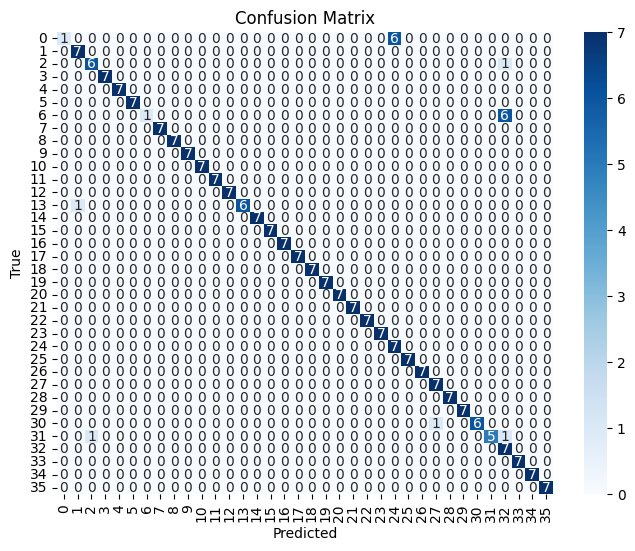

In [65]:

# Confusion Matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
print("Confusion Matrix:")
print(conf_matrix)

# Classification Report
class_report = classification_report(y_true_classes, y_pred_classes)
print("Classification Report:")
print(class_report)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.arange(num_classes), yticklabels=np.arange(num_classes))
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

---
# 6. CNN Model
<span id="Importmodules"></span>

---

In [66]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import joblib
import numpy as np

# Load the features and labels for train, validation, and test sets
X_train_features, y_train_labels = joblib.load('train_split.joblib')
X_val, y_val = joblib.load('val_split.joblib')
X_test_features, y_test_labels = joblib.load('test.joblib')

# Print the shape of the features to confirm
print(f"X_train_features shape: {X_train_features.shape}")
print(f"y_train_labels shape: {y_train_labels.shape}")
print(f"X_test_features shape: {X_test_features.shape}")
print(f"y_test_labels shape: {y_test_labels.shape}")

# Define the fully connected model for the extracted features
model = Sequential()

# Input layer (feature vectors of size 1024)
model.add(Dense(1024, activation='relu', input_shape=(X_train_features.shape[1],)))
model.add(Dropout(0.5))  # Dropout to reduce overfitting

# Hidden layers
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))

# Output layer (number of classes)
model.add(Dense(y_train_labels.shape[1], activation='softmax'))

# Compile the model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train_features, y_train_labels, 
                    epochs=10, batch_size=32, 
                    validation_data=(X_val, y_val))

X_train_features shape: (1810, 1024)
y_train_labels shape: (1810, 36)
X_test_features shape: (252, 1024)
y_test_labels shape: (252, 36)
Epoch 1/10
57/57 [==============================] - 4s 33ms/step - loss: 3.6623 - accuracy: 0.0696 - val_loss: 3.0089 - val_accuracy: 0.2826
Epoch 2/10
57/57 [==============================] - 2s 26ms/step - loss: 2.7858 - accuracy: 0.2000 - val_loss: 1.9588 - val_accuracy: 0.4503
Epoch 3/10
57/57 [==============================] - 1s 25ms/step - loss: 2.0750 - accuracy: 0.3365 - val_loss: 1.3366 - val_accuracy: 0.6556
Epoch 4/10
57/57 [==============================] - 2s 29ms/step - loss: 1.5593 - accuracy: 0.4796 - val_loss: 0.8469 - val_accuracy: 0.7417
Epoch 5/10
57/57 [==============================] - 2s 29ms/step - loss: 1.1882 - accuracy: 0.5702 - val_loss: 0.5804 - val_accuracy: 0.8477
Epoch 6/10
57/57 [==============================] - 2s 28ms/step - loss: 0.9609 - accuracy: 0.6657 - val_loss: 0.4343 - val_accuracy: 0.8653
Epoch 7/10
57/57 [

In [67]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test_features, y_test_labels)
print(f"Test accuracy: {test_accuracy:.4f}")
print(f"Test loss: {test_loss:.4f}")

8/8 [==============================] - 0s 6ms/step - loss: 0.1528 - accuracy: 0.9325
Test accuracy: 0.9325
Test loss: 0.1528


---
# 7. Plot training and validation accuracy
<span id="Importmodules"></span>

---

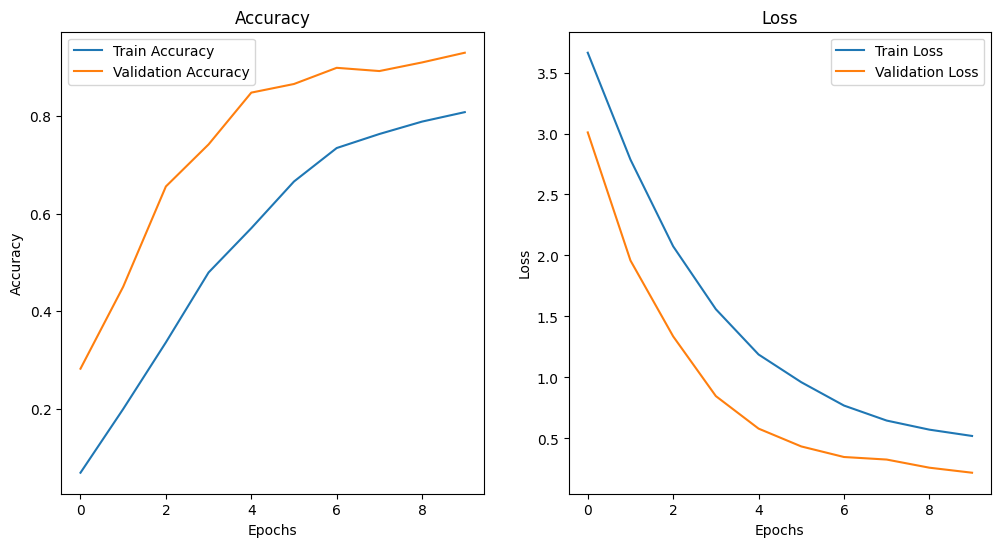

In [68]:
# Plot accuracy and loss
plt.figure(figsize=(12, 6))

# Plot training & validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

---
# 8. Confusion Matrix and Classification Report
<span id="Importmodules"></span>

---

8/8 [==============================] - 0s 6ms/step
Confusion Matrix:
[[2 0 0 ... 0 0 0]
 [0 7 0 ... 0 0 0]
 [0 0 7 ... 0 0 0]
 ...
 [0 0 0 ... 7 0 0]
 [0 0 0 ... 0 7 0]
 [0 0 0 ... 0 0 7]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.29      0.44         7
           1       0.88      1.00      0.93         7
           2       1.00      1.00      1.00         7
           3       1.00      1.00      1.00         7
           4       1.00      1.00      1.00         7
           5       1.00      1.00      1.00         7
           6       0.50      1.00      0.67         7
           7       1.00      1.00      1.00         7
           8       1.00      1.00      1.00         7
           9       1.00      1.00      1.00         7
          10       1.00      1.00      1.00         7
          11       1.00      1.00      1.00         7
          12       1.00      1.00      1.00         7
          13       1.00      0.

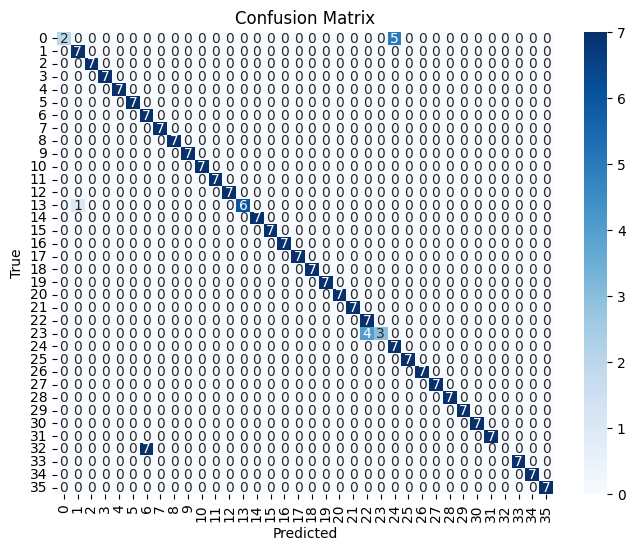

In [69]:
# Make predictions on the test set
y_pred = model.predict(X_test_features)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test_labels, axis=1)

# Confusion Matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
print("Confusion Matrix:")
print(conf_matrix)

# Classification Report
class_report = classification_report(y_true_classes, y_pred_classes)
print("Classification Report:")
print(class_report)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.arange(num_classes), yticklabels=np.arange(num_classes))
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [74]:
# Extract class names from the training data generator
class_indices = train_data_gen.class_indices  # This gives a dictionary mapping class names to indices
class_names = [key for key, _ in sorted(class_indices.items(), key=lambda item: item[1])]

print("Class Names:", class_names)

Class Names: ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [71]:
model.save('cnn_model.h5')

In [72]:
import tensorflow as tf
from tensorflow.keras.models import load_model

# Load the saved model
model = load_model('cnn_model.h5')

# Summarize the model to understand its architecture
model.summary()

# Save the model weights separately (optional, for reference)
model.save_weights('model_weights.h5')

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_14 (Dense)            (None, 1024)              1049600   
                                                                 
 dropout_12 (Dropout)        (None, 1024)              0         
                                                                 
 dense_15 (Dense)            (None, 512)               524800    
                                                                 
 dropout_13 (Dropout)        (None, 512)               0         
                                                                 
 dense_16 (Dense)            (None, 256)               131328    
                                                                 
 dropout_14 (Dropout)        (None, 256)               0         
                                                                 
 dense_17 (Dense)            (None, 36)               

In [ ]:
import tensorflow as tf
import torch
import torch.nn as nn
import torchvision.models as models
import datetime
import numpy as np

# Step 1: Define the CustomModel with MobileNetV2 base
class CustomModel(nn.Module):
    def __init__(self, num_classes=26):  # 26 classes for A-Z
        super(CustomModel, self).__init__()
        # Use MobileNetV2 features (pre-trained or initialized)
        self.mobilenet = models.mobilenet_v2(pretrained=False).features
        # Global average pooling to reduce 1280 to 1x1x1280
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))
        # Transition layer to match .h5's 1024 input
        self.transition = nn.Linear(1280, 1024)
        # Dense layers from .h5 (adjusted to 26 classes)
        self.classifier = nn.Sequential(
            nn.Linear(1024, 1024),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(256, num_classes)  # Adjusted to 26 classes (A-Z)
        )

    def forward(self, x):
        x = self.mobilenet(x)
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)  # Flatten to (batch_size, 1280)
        x = self.transition(x)     # Reduce to 1024
        x = self.classifier(x)
        return x

# Step 2: Load .h5 model and extract weights
model_h5 = tf.keras.models.load_model("cnn_model.h5")  # Replace with your .h5 path
weights_dict = {layer.name: layer.get_weights() for layer in model_h5.layers if layer.get_weights()}

# Step 3: Initialize PyTorch model
model_pt = CustomModel(num_classes=26)
model_pt.eval()

# Step 4: Map weights from .h5 to PyTorch model
state_dict = model_pt.state_dict()
with torch.no_grad():
    # Transition layer (1280 -> 1024) - Initialize randomly since not in .h5
    nn.init.xavier_uniform_(model_pt.transition.weight)
    nn.init.zeros_(model_pt.transition.bias)

    # Dense layers (adjust last layer to 26 classes)
    model_pt.classifier[0].weight.copy_(torch.from_numpy(weights_dict['dense_2'][0].T))  # Transpose for FC layers
    model_pt.classifier[0].bias.copy_(torch.from_numpy(weights_dict['dense_2'][1]))
    model_pt.classifier[3].weight.copy_(torch.from_numpy(weights_dict['dense_3'][0].T))
    model_pt.classifier[3].bias.copy_(torch.from_numpy(weights_dict['dense_3'][1]))
    model_pt.classifier[6].weight.copy_(torch.from_numpy(weights_dict['dense_4'][0].T))
    model_pt.classifier[6].bias.copy_(torch.from_numpy(weights_dict['dense_4'][1]))
    # Adjust dense_5 (256 -> 36) to (256 -> 26)
    model_pt.classifier[9].weight.copy_(torch.from_numpy(weights_dict['dense_5'][0][:, :26].T))  # Take first 26 classes (A-Z)
    model_pt.classifier[9].bias.copy_(torch.from_numpy(weights_dict['dense_5'][1][:26]))

# Step 5: Save as Ultralytics checkpoint (matching model.pt format)
checkpoint = {
    'date': datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'version': '1.0',
    'license': 'AGPL-3.0',
    'docs': 'https://docs.ultralytics.com',
    'epoch': -1,
    'best_fitness': 0.0,
    'model': model_pt.state_dict(),
    'ema': None,
    'updates': 0,
    'optimizer': None,
    'train_args': {},
    'train_metrics': {},
    'train_results': {}
}

output_path = "model.pt"
torch.save(checkpoint, output_path)
print(f"Model successfully converted and saved as '{output_path}' in Ultralytics checkpoint format.")

Model successfully converted and saved as 'converted_model.pt' in Ultralytics checkpoint format.
